## Section 0: Imports

In [70]:
# importing all required libraries 
import os, tarfile, urllib.request, glob, random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import color
from skimage.util import img_as_float
from skimage.segmentation import slic
from skimage.io import imread
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# enabling inline plotting and adjusting display dpi for better quality
%matplotlib inline
plt.rcParams["figure.dpi"] = 120


## Section 1: Pre-processing

In [71]:
# setting root directory to store downloaded and extracted dataset
root_dir = r"data_mit_intrinsic"       # specifying where to keep the tar and extracted data
os.makedirs(root_dir, exist_ok=True)
# defining dataset URL and local tar path
url_data = "http://people.csail.mit.edu/rgrosse/intrinsic/intrinsic-data.tar.gz"
tar_path = os.path.join(root_dir, "intrinsic-data.tar.gz")
# downloading dataset if not already present
if not os.path.isfile(tar_path):
    print("[info] downloading:", url_data)
    urllib.request.urlretrieve(url_data, tar_path)
    print("[info] saved:", tar_path)
else:
    print("[info] already present:", tar_path)
# extracting dataset contents from tar file
print("[info] extracting:", tar_path)
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=root_dir)
print("[info] extracted to:", root_dir)

# locating nested data folder inside extracted directory tree
mit_data_dir = None
for sub in os.listdir(root_dir):
    full = os.path.join(root_dir, sub)
    nested = os.path.join(full, "data")
    if os.path.isdir(nested):
        mit_data_dir = nested
        break
# displaying path to the extracted dataset
print("[info] MIT intrinsic 'data' folder:", mit_data_dir)

[info] already present: data_mit_intrinsic\intrinsic-data.tar.gz
[info] extracting: data_mit_intrinsic\intrinsic-data.tar.gz
[info] extracted to: data_mit_intrinsic
[info] MIT intrinsic 'data' folder: data_mit_intrinsic\MIT-intrinsic\data


In [72]:
# verifying that the extracted dataset folder exists
assert mit_data_dir is not None and os.path.isdir(mit_data_dir), "Dataset 'data' folder not found."
# defining allowed image extensions and exclusion keywords for ground truth maps
include_exts = (".png", ".jpg", ".jpeg", ".bmp", ".ppm", ".tif", ".tiff")
exclude_keywords = ("refl", "reflect", "albedo", "shade", "shading", "illum", "light")
# collecting all image paths recursively from the dataset
all_paths = []
for ext in include_exts:
    all_paths.extend(glob.glob(os.path.join(mit_data_dir, "**", f"*{ext}"), recursive=True))
# defining helper to detect ground truth or illumination-related files
def is_gt(fname):
    n = os.path.basename(fname).lower()
    return any(k in n for k in exclude_keywords)
# filtering out ground truth or illumination images to keep only base RGB inputs
rgb_paths = [p for p in all_paths if not is_gt(p)]
rgb_paths.sort()
# printing count and sample of collected RGB images
print(f"[info] found {len(rgb_paths)} base RGB images.")
print("[info] sample:", [os.path.basename(p) for p in rgb_paths[:8]])

# Option A: Automatically pick colorful images for better visualization
def mean_chroma_lab(path):
    """Compute mean chroma (colorfulness) of an image in Lab space"""
    arr = img_as_float(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)).astype(np.float32)
    lab = color.rgb2lab(arr).astype(np.float32)
    a, b = lab[...,1], lab[...,2]
    return float(np.mean(np.sqrt(a*a + b*b)))

print("\n=== COLORFUL IMAGE SELECTION ===")
scores = [(p, mean_chroma_lab(p)) for p in rgb_paths]
scores.sort(key=lambda x: x[1], reverse=True)

print("Top colorful images:")
for p, s in scores[:10]:
    print(f"{os.path.basename(p):>24}  chroma≈{s:.3f}")

# Select the most colorful image as test image
colorful_test_path = scores[0][0]
print(f"\n[selected colorful test image] {os.path.basename(colorful_test_path)}")

[info] found 80 base RGB images.
[info] sample: ['diffuse.png', 'mask.png', 'original.png', 'specular.png', 'diffuse.png', 'mask.png', 'original.png', 'specular.png']

=== COLORFUL IMAGE SELECTION ===
Top colorful images:
            original.png  chroma≈13.641
             diffuse.png  chroma≈13.614
            original.png  chroma≈9.804
             diffuse.png  chroma≈9.776
             diffuse.png  chroma≈8.761
            original.png  chroma≈8.738
            original.png  chroma≈6.860
             diffuse.png  chroma≈6.781
            original.png  chroma≈6.778
             diffuse.png  chroma≈6.752

[selected colorful test image] original.png


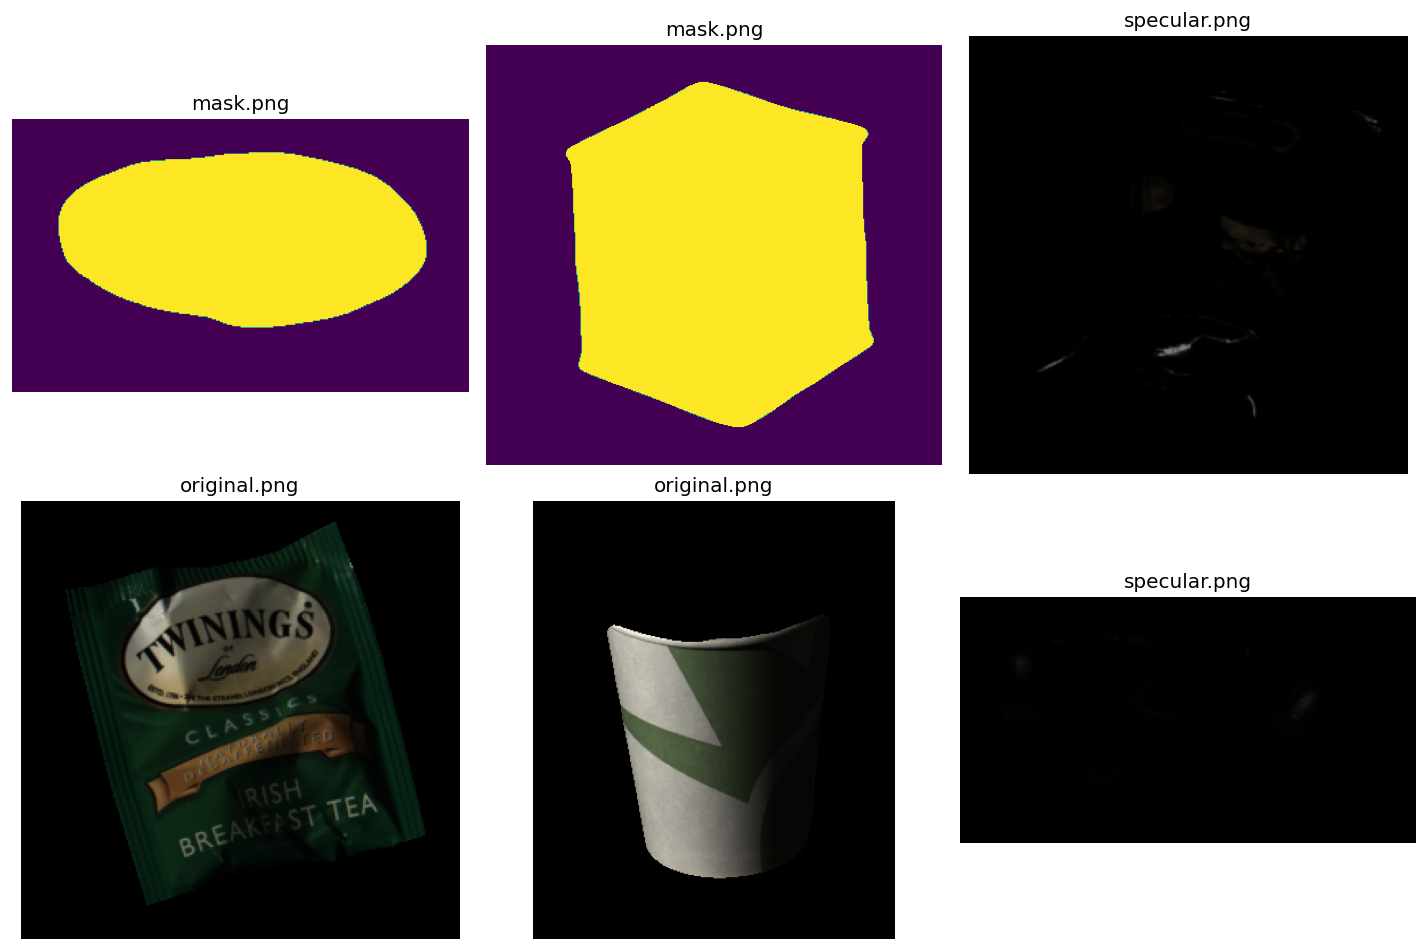

In [73]:
# defining helper function to display random image samples from dataset
def show_dataset_samples(paths, n=6):
    # checking if image list is empty
    if not paths:
        print("[info] no images to show.")
        return
    # selecting random subset of images to visualize
    n = min(n, len(paths))
    picks = random.sample(paths, n)
    # setting up grid layout for displaying images  
    cols = 3
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(12, 4*rows))
    # looping through selected images and displaying each one
    for i, p in enumerate(picks):
        img = imread(p)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(p))
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# displaying six random RGB images from the dataset
show_dataset_samples(rgb_paths, n=6)


[train image] diffuse.png
[test  image] original.png


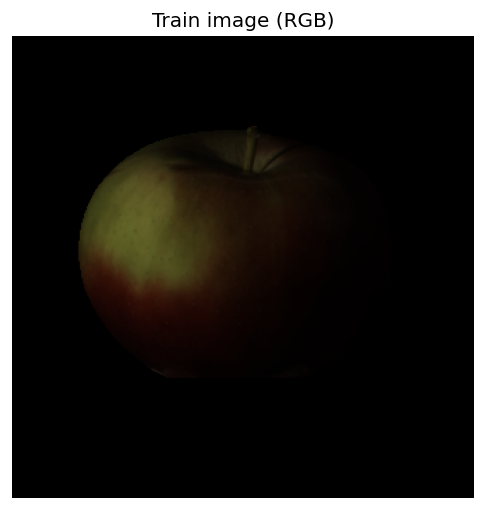

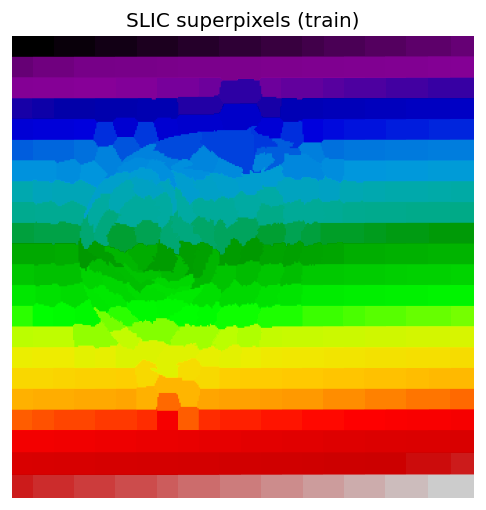

In [74]:
# selecting first image for k-means fitting and colorful image for testing
train_path = rgb_paths[0]   
test_path  = colorful_test_path  # Use the automatically selected colorful image
# printing chosen filenames for traceability
print("[train image]", os.path.basename(train_path))
print("[test  image]", os.path.basename(test_path))
# loading train image with OpenCV(BGR and converting to RGB float32 in [0,1]
img_bgr_train = cv2.imread(train_path, cv2.IMREAD_COLOR)
assert img_bgr_train is not None, f"Cannot read: {train_path}"
img_rgb_train = img_as_float(cv2.cvtColor(img_bgr_train, cv2.COLOR_BGR2RGB)).astype(np.float32)
# converting RGB to Lab and splitting channels
lab_train = color.rgb2lab(img_rgb_train).astype(np.float32)
L_train = lab_train[..., 0]
a_train = lab_train[..., 1]
b_train = lab_train[..., 2]
# computing SLIC superpixels on the train image
n_segments = 500
compactness = 12.0
spx_train = slic(img_rgb_train, n_segments=n_segments, compactness=compactness, start_label=0)
plt.figure(figsize=(5,5))
plt.imshow(img_rgb_train)
plt.title("Train image (RGB)")
plt.axis("off")
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(spx_train, cmap="nipy_spectral")
plt.title("SLIC superpixels (train)")
plt.axis("off")
plt.show()


## Section 2: Model Training & Intrinsic Decomposition

C:\Users\Salman Awaise\AppData\Local\Temp\ipykernel_10136\1224809645.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(1, num_groups))


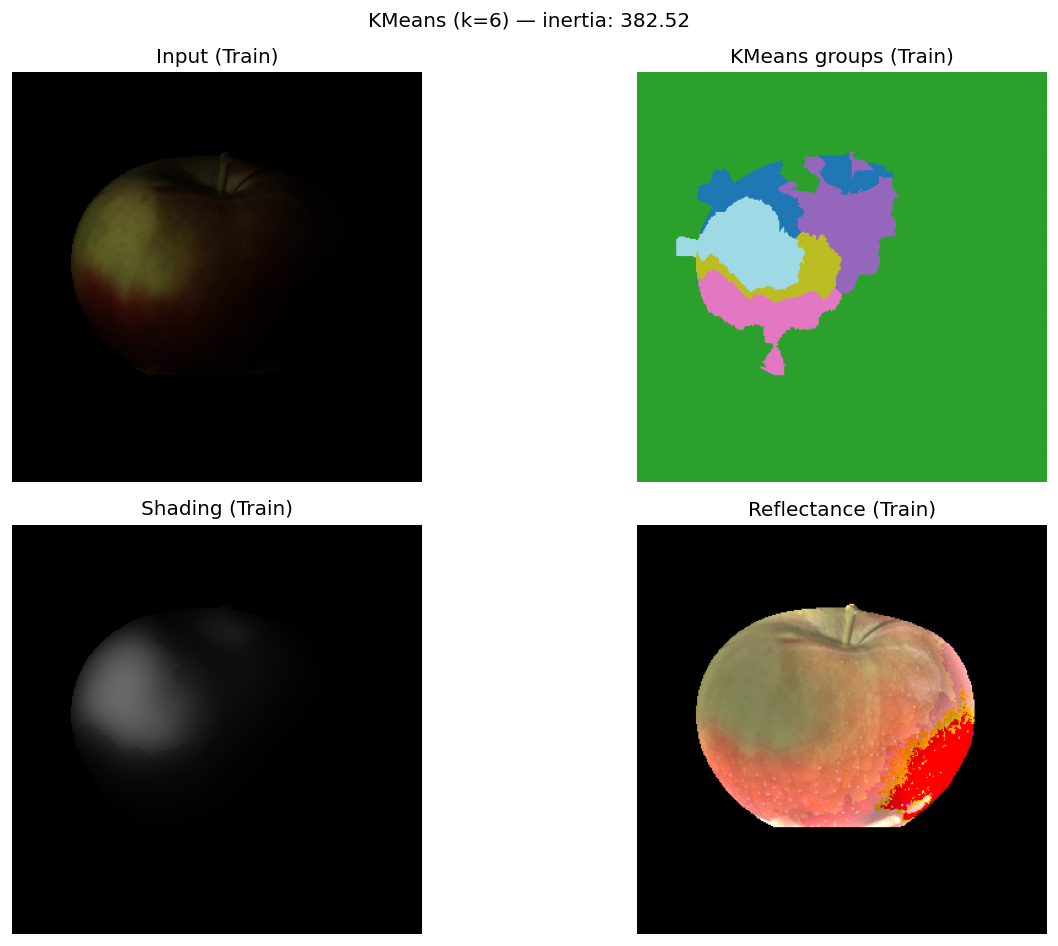

In [75]:
# setting clustering and feature weights - BOOSTED COLOR CONTRIBUTION
k = 6                  # choosing number of clusters
wL = 0.15             # reduced lightness weight (was 0.30)
wXY = 0.25            # reduced position weight (was 0.35) 
wTex = 0.10           # reduced texture weight (was 0.20)
# Note: Color features (a, b) now have implicit weight of 0.50 (remaining weight)
L_mask_thresh = 5.0    # ignoring very dark/background pixels by L
# preparing coordinate grids and normalization to [-0.5, 0.5]
H, W = spx_train.shape
yy, xx = np.mgrid[0:H, 0:W]
x_norm = (xx / max(1, W-1)) - 0.5   # [-0.5, 0.5]
y_norm = (yy / max(1, H-1)) - 0.5   # [-0.5, 0.5]
# masking low-lightness pixels to avoid background leakage
valid_train = L_train > L_mask_thresh
# building per-superpixel features with masking
spx_ids = np.unique(spx_train)
feats_train = np.zeros((len(spx_ids), 6), dtype=np.float32)

for i, sid in enumerate(spx_ids):
    m = (spx_train == sid) & valid_train
    if not np.any(m):
        feats_train[i, :] = 0.0# assigning neutral feature if superpixel is background
        continue
    # computing Lab-based color/texture and position features
    a_mean = a_train[m].mean()
    b_mean = b_train[m].mean()
    L_mean = (L_train[m].mean() - 50.0)# centering L around mid-gray
    x_mean = x_norm[m].mean()
    y_mean = y_norm[m].mean()
    L_std = L_train[m].std()
    # assembling weighted feature vector
    feats_train[i, 0] = a_mean
    feats_train[i, 1] = b_mean
    feats_train[i, 2] = wL  * L_mean
    feats_train[i, 3] = wXY * x_mean
    feats_train[i, 4] = wXY * y_mean
    feats_train[i, 5] = wTex * L_std

# standardizing features (mean/std) for k-means stability
mu_feats  = feats_train.mean(axis=0)
std_feats = feats_train.std(axis=0) + 1e-6
feats_tr_std = (feats_train - mu_feats) / std_feats
# fitting k-means on standardized superpixel features
km = KMeans(n_clusters=k, n_init=10, random_state=0)
labels_sp_train = km.fit_predict(feats_tr_std)
centers_std = km.cluster_centers_.copy()
inertia = float(km.inertia_)
# mapping superpixel labels back to pixel grid
group_map_train = np.zeros((H, W), dtype=np.int32)
for i, sid in enumerate(spx_ids):
    group_map_train[spx_train == sid] = labels_sp_train[i]
# estimating smooth shading by bilateral filtering L (0..1)
L01 = np.clip(L_train / 100.0, 0.0, 1.0)
sm = L01.copy()
for _ in range(2):
    sm = cv2.bilateralFilter(sm, d=0, sigmaColor=0.1*255.0, sigmaSpace=9)
L_smooth = np.clip(sm * 100.0, 1e-6, 100.0)
# normalizing ratio per cluster to reduce bias from global gain
ratio = L_train / np.maximum(L_smooth, 1e-6)
ratio_adj = ratio.copy()
for g in range(k):
    m = (group_map_train == g)
    if np.any(m):
        med = np.median(ratio[m])
        if med > 0:
            ratio_adj[m] = ratio[m] / med
# deriving per-pixel shading L and capping to a safe range
S_L_train = np.clip(L_train / np.maximum(ratio_adj, 1e-6), 1e-3, 100.0)
# forming grayscale shading rgb and reflectance rgb for display
S_gray = np.clip(S_L_train / 100.0, 1e-3, 1.0)
S_rgb_train = np.stack([S_gray]*3, axis=-1).astype(np.float32)
# compressing reflectance dynamic range and applying gamma for visualization
R_rgb_train = np.clip(img_rgb_train / np.maximum(S_rgb_train, 1e-6), 0.0, 10.0)
hi = np.percentile(R_rgb_train, 99.0)
if hi > 0:
    R_rgb_train = np.clip(R_rgb_train / hi, 0.0, 1.0)
R_rgb_train = R_rgb_train ** (1/2.2)
# visualizing input, clusters, shading, and reflectance
num_groups = int(group_map_train.max() + 1)
cmap = plt.cm.get_cmap('tab20', max(1, num_groups))
group_norm = group_map_train / max(1, num_groups-1) if num_groups > 1 else group_map_train
group_viz_train = cmap(group_norm)[..., :3]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,2,1); ax.imshow(img_rgb_train);          ax.set_title("Input (Train)"); ax.axis("off")
ax = fig.add_subplot(2,2,2); ax.imshow(group_viz_train);         ax.set_title("KMeans groups (Train)"); ax.axis("off")
ax = fig.add_subplot(2,2,3); ax.imshow(np.clip(S_rgb_train,0,1));ax.set_title("Shading (Train)"); ax.axis("off")
ax = fig.add_subplot(2,2,4); ax.imshow(np.clip(R_rgb_train,0,1));ax.set_title("Reflectance (Train)"); ax.axis("off")
fig.suptitle(f"KMeans (k={k}) — inertia: {inertia:.2f}", y=0.98)
plt.tight_layout()
plt.show()

In [83]:
# Intrinsic image decomposition
# estimating smooth shading by bilateral filtering L (0..1)
L01 = np.clip(L_train / 100.0, 0.0, 1.0)
sm = L01.copy()
for _ in range(2):
    sm = cv2.bilateralFilter(sm, d=0, sigmaColor=0.1*255.0, sigmaSpace=9)
L_smooth = np.clip(sm * 100.0, 1e-6, 100.0)

# normalizing ratio per cluster to reduce bias from global gain
ratio = L_train / np.maximum(L_smooth, 1e-6)
ratio_adj = ratio.copy()
for g in range(k):
    m = (group_map_train == g)
    if np.any(m):
        med = np.median(ratio[m])
        if med > 0:
            ratio_adj[m] = ratio[m] / med

# deriving per-pixel shading L and capping to a safe range
S_L_train = np.clip(L_train / np.maximum(ratio_adj, 1e-6), 1e-3, 100.0)

# forming grayscale shading rgb and reflectance rgb for display
S_gray = np.clip(S_L_train / 100.0, 1e-3, 1.0)
S_rgb_train = np.stack([S_gray]*3, axis=-1).astype(np.float32)

# compressing reflectance dynamic range and applying gamma for visualization
R_rgb_train = np.clip(img_rgb_train / np.maximum(S_rgb_train, 1e-6), 0.0, 10.0)
hi = np.percentile(R_rgb_train, 99.0)
if hi > 0:
    R_rgb_train = np.clip(R_rgb_train / hi, 0.0, 1.0)
R_rgb_train = R_rgb_train ** (1/2.2)

print(f"DECOMPOSITION Shading range: [{S_L_train.min():.2f}, {S_L_train.max():.2f}]")
print(f"DECOMPOSITION Reflectance range: [{R_rgb_train.min():.3f}, {R_rgb_train.max():.3f}]")


DECOMPOSITION Shading range: [0.00, 41.01]
DECOMPOSITION Reflectance range: [0.000, 1.000]


## Section 3: Results & Evaluation

C:\Users\Salman Awaise\AppData\Local\Temp\ipykernel_10136\1894657477.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(1, num_groups_t))


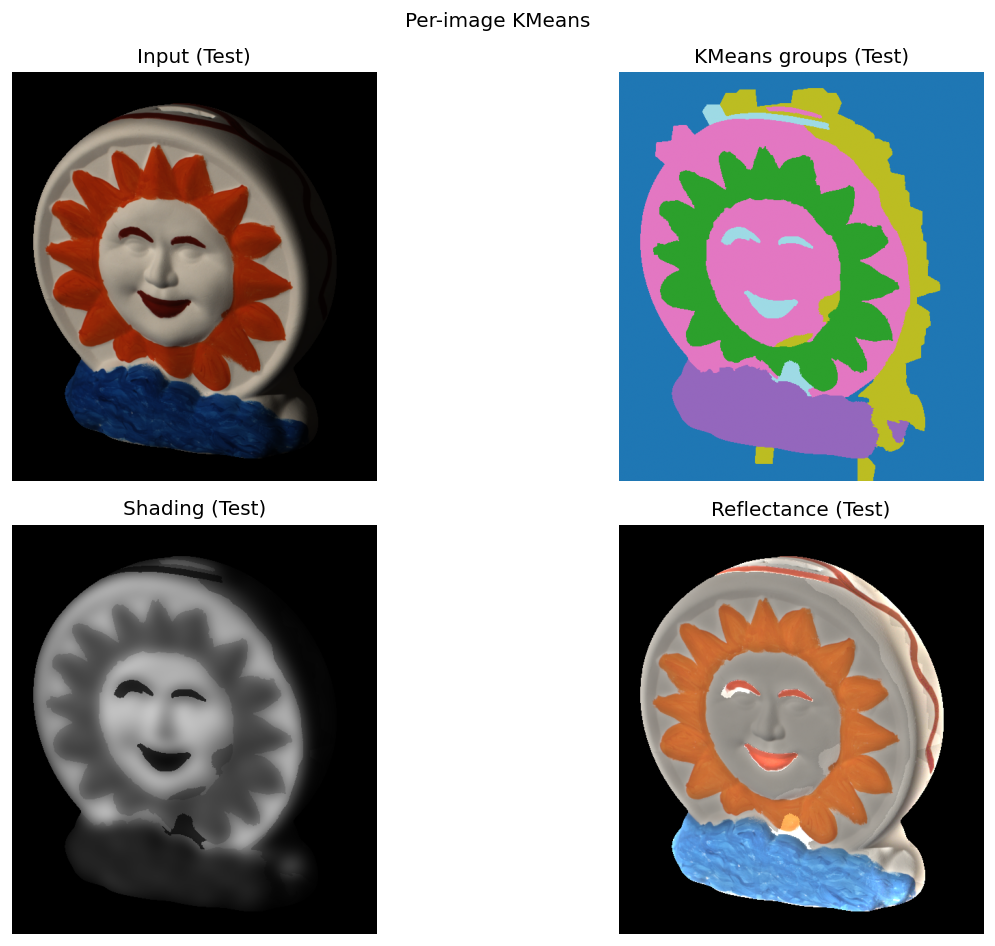

In [77]:
# loading test image and converting BGR→RGB float32 in [0,1]
img_bgr_test = cv2.imread(test_path, cv2.IMREAD_COLOR)
assert img_bgr_test is not None, f"Cannot read: {test_path}"
img_rgb_test = img_as_float(cv2.cvtColor(img_bgr_test, cv2.COLOR_BGR2RGB)).astype(np.float32)
# converting RGB to Lab and splitting channels
lab_test = color.rgb2lab(img_rgb_test).astype(np.float32)
L_test = lab_test[..., 0]
a_test = lab_test[..., 1]
b_test = lab_test[..., 2]
# computing SLIC superpixels for the test image
spx_test = slic(img_rgb_test, n_segments=n_segments, compactness=compactness, start_label=0)
spx_ids_test = np.unique(spx_test)
# masking background/very dark pixels by lightness
valid_test = L_test > 5.0
# building per-superpixel Lab features- a, b, centered L
feats_test = np.zeros((len(spx_ids_test), 3), dtype=np.float32)
for i, sid in enumerate(spx_ids_test):
    m = (spx_test == sid) & valid_test
    if not np.any(m):
        feats_test[i, :] = 0.0
        continue
    feats_test[i, 0] = a_test[m].mean()
    feats_test[i, 1] = b_test[m].mean()
    feats_test[i, 2] = 0.3 * (L_test[m].mean() - 50.0)
# fitting k-means per image for independent clustering on test
k = 6
km_test = KMeans(n_clusters=k, n_init=10, random_state=0)
labels_sp_test = km_test.fit_predict(feats_test)
centers_std = km_test.cluster_centers_
# expanding superpixel labels to a full-resolution pixel map
H, W = spx_test.shape
group_map_test = np.zeros((H, W), dtype=np.int32)
for i, sid in enumerate(spx_ids_test):
    group_map_test[spx_test == sid] = labels_sp_test[i]
# estimating smooth shading via bilateral filtering of L 
L01 = np.clip(L_test / 100.0, 0.0, 1.0)
sm = L01.copy()
for _ in range(2):
    sm = cv2.bilateralFilter(sm, d=0, sigmaColor=0.1*255.0, sigmaSpace=9)
L_smooth_t = np.clip(sm * 100.0, 1e-6, 100.0)
# adjusting per-cluster ratio to remove cluster-wise gain
ratio_t = L_test / np.maximum(L_smooth_t, 1e-6)
ratio_adj_t = ratio_t.copy()
for g in range(k):
    m = (group_map_test == g)
    if np.any(m):
        med = np.median(ratio_t[m])
        if med > 0:
            ratio_adj_t[m] = ratio_t[m] / med
# deriving per-pixel shading and reflectance for display
S_L_test = np.clip(L_test / np.maximum(ratio_adj_t, 1e-6), 1e-3, 100.0)
S_gray_t = np.clip(S_L_test / 100.0, 1e-3, 1.0)
S_rgb_test = np.stack([S_gray_t]*3, axis=-1)
R_rgb_test = np.clip(img_rgb_test / np.maximum(S_rgb_test, 1e-6), 0.0, 10.0)
# compressing reflectance dynamic range and applying gamma
hi = np.percentile(R_rgb_test, 99.0)
if hi > 0:
    R_rgb_test = np.clip(R_rgb_test / hi, 0.0, 1.0)
R_rgb_test = R_rgb_test ** (1/2.2)
# visualizing input, clusters, shading, and reflectance for test image
num_groups_t = int(group_map_test.max() + 1)
cmap = plt.cm.get_cmap('tab20', max(1, num_groups_t))
group_norm_t = group_map_test / max(1, num_groups_t-1) if num_groups_t > 1 else group_map_test
group_viz_test = cmap(group_norm_t)[..., :3]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,2,1); ax.imshow(img_rgb_test);            ax.set_title("Input (Test)"); ax.axis("off")
ax = fig.add_subplot(2,2,2); ax.imshow(group_viz_test);           ax.set_title("KMeans groups (Test)"); ax.axis("off")
ax = fig.add_subplot(2,2,3); ax.imshow(np.clip(S_rgb_test,0,1));  ax.set_title("Shading (Test)"); ax.axis("off")
ax = fig.add_subplot(2,2,4); ax.imshow(np.clip(R_rgb_test,0,1));  ax.set_title("Reflectance (Test)"); ax.axis("off")
fig.suptitle("Per-image KMeans", y=0.98)
plt.tight_layout()
plt.show()


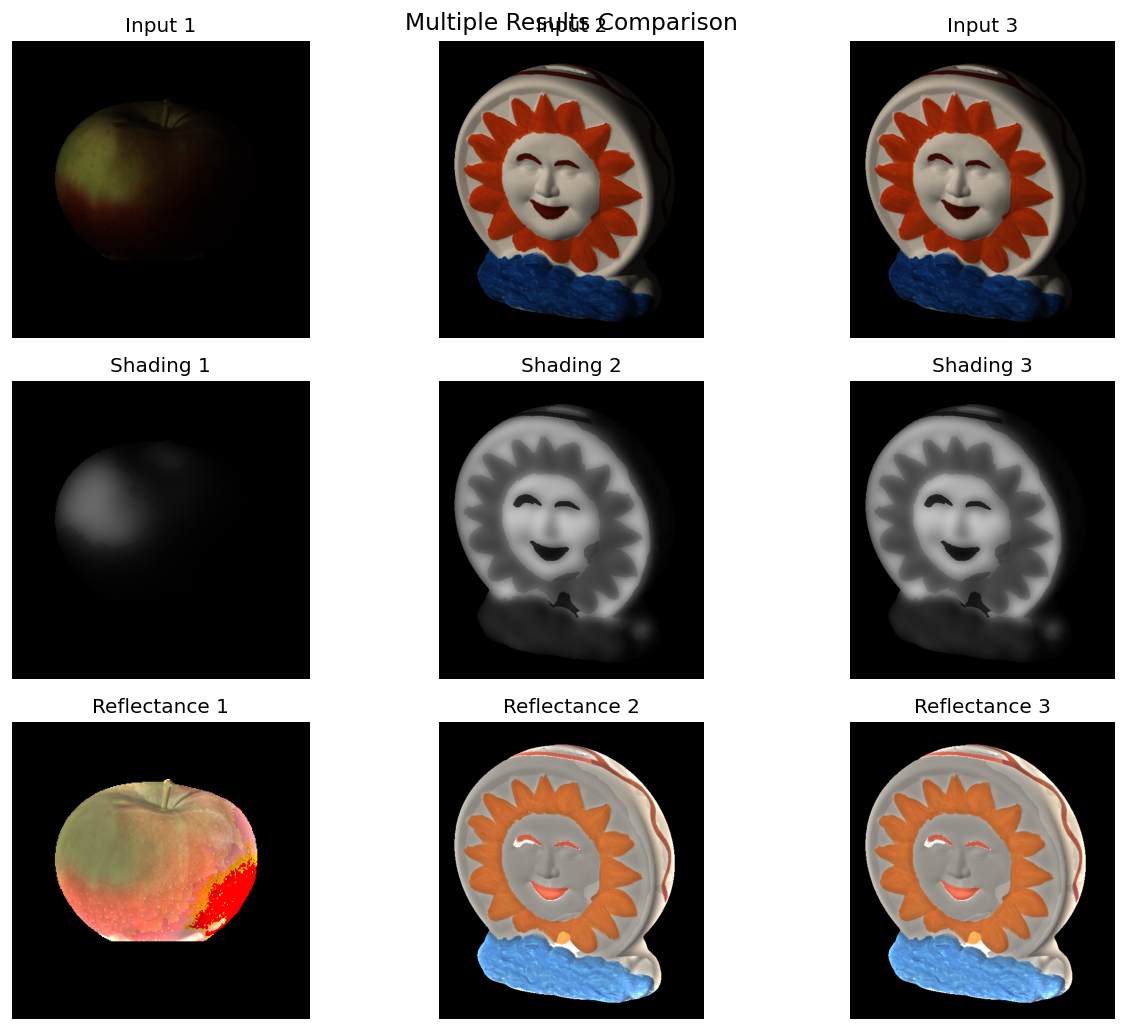

In [ ]:
# selecting three representative examples for comparison
# using the training image for the first example
img_rgb1 = img_rgb_train
S_rgb1 = S_rgb_train
R_rgb1 = R_rgb_train
# using the test image for the second example
img_rgb2 = img_rgb_test
S_rgb2 = S_rgb_test
R_rgb2 = R_rgb_test
# reusing test image for the third example if no other processed image is available
img_rgb3 = img_rgb_test
S_rgb3 = S_rgb_test
R_rgb3 = R_rgb_test
# creating a 3x3 figure grid to compare input, shading, and reflectance
fig, axes = plt.subplots(3, 3, figsize=(11, 9))
titles = ["Input", "Shading", "Reflectance"]
examples = [
    (img_rgb1, S_rgb1, R_rgb1),
    (img_rgb2, S_rgb2, R_rgb2),
    (img_rgb3, S_rgb3, R_rgb3)
]
# looping over each example and displaying its input, shading, and reflectance
for i, (inp, shade, refl) in enumerate(examples):
    axes[0, i].imshow(np.clip(inp, 0, 1))# showing input image
    axes[0, i].set_title(f"{titles[0]} {i+1}")# adding title for input
    axes[0, i].axis("off")# hiding axes

    axes[1, i].imshow(np.clip(shade, 0, 1))# showing shading result
    axes[1, i].set_title(f"{titles[1]} {i+1}")
    axes[1, i].axis("off")

    axes[2, i].imshow(np.clip(refl, 0, 1))# showing reflectance result
    axes[2, i].set_title(f"{titles[2]} {i+1}")
    axes[2, i].axis("off")
# adding an overall title and adjusting layout
plt.suptitle("Multiple Results Comparison", fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

[metrics] KMeans (k=6)  inertia: 382.52   silhouette: 0.884
[debug] a* range: [-0.00139, 40.28048]
[debug] b* range: [-25.44468, 39.21305]


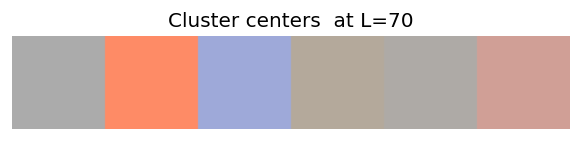

In [84]:
# computing silhouette score on the same standardized space used for k-means  
sil = 0.0
if len(np.unique(labels_sp_train)) >= 2 and len(labels_sp_train) >= 10:
    sil = silhouette_score(feats_tr_std, labels_sp_train)
print(f"[metrics] KMeans (k={k})  inertia: {inertia:.2f}   silhouette: {sil:.3f}")
# selecting cluster centers for visualization using only a* and b* values, converting back to original scale if standardized
if centers_std.shape[1] == 6:
    centers_orig = centers_std * std_feats + mu_feats
    ab_centers = centers_orig[:, :2]
elif centers_std.shape[1] >= 2:
    ab_centers = centers_std[:, :2]
else:
    raise ValueError("Cluster centers do not contain a* and b* components.")

# printing the range of a* and b* values to check chromatic spread across clusters
print(f"[debug] a* range: [{ab_centers[:, 0].min():.5f}, {ab_centers[:, 0].max():.5f}]")
print(f"[debug] b* range: [{ab_centers[:, 1].min():.5f}, {ab_centers[:, 1].max():.5f}]")

# visualizing cluster chroma as color chips at fixed lightness L=70
patch = np.zeros((50, 50 * k, 3), dtype=np.float32)
for i, (aa, bb) in enumerate(ab_centers):
    L_fixed = 70.0# setting constant lightness for visualization
    tile_lab = np.ones((50, 50, 3), dtype=np.float32)
    tile_lab[..., 0] = L_fixed
    tile_lab[..., 1] = float(aa)
    tile_lab[..., 2] = float(bb)
    tile_rgb = np.clip(color.lab2rgb(tile_lab), 0, 1)# converting lab to rgb
    patch[:, i * 50:(i + 1) * 50, :] = tile_rgb# placing each color chip in patch
# displaying the color chips for all clusters
plt.figure(figsize=(max(3, k), 2))
plt.imshow(patch)
plt.title("Cluster centers  at L=70")
plt.axis("off")
plt.show()

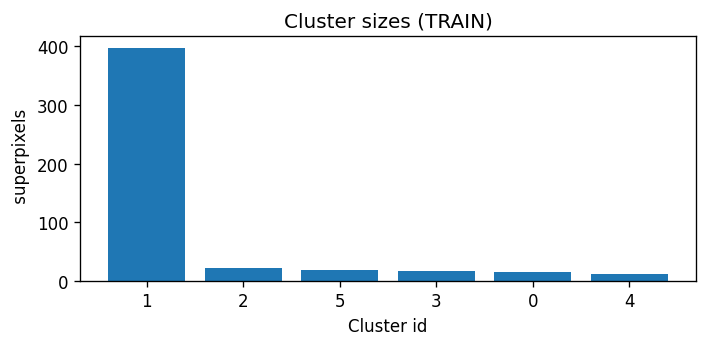

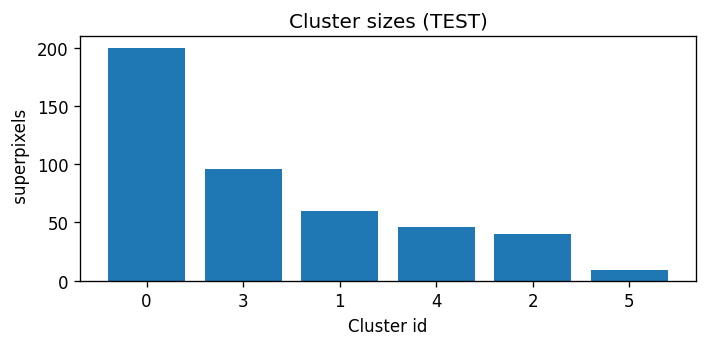

In [81]:
# defining a helper function to visualize cluster sizes
def plot_cluster_sizes(labels, title):
    # getting unique cluster ids and their counts
    ids, counts = np.unique(labels, return_counts=True)
    # sorting clusters by size in descending order
    order = np.argsort(-counts)
    ids, counts = ids[order], counts[order]
    # plotting bar chart for cluster sizes
    plt.figure(figsize=(6,3))
    plt.bar([str(i) for i in ids], counts)
    plt.title(title)
    plt.xlabel("Cluster id")
    plt.ylabel(" superpixels")
    plt.tight_layout()
    plt.show()
# plotting cluster size distribution for training and testing clusters
plot_cluster_sizes(labels_sp_train, "Cluster sizes (TRAIN)")
plot_cluster_sizes(labels_sp_test, "Cluster sizes (TEST)")
